# DataLab Cup 2: CNN for Object Detection
<hr>

Team Name: 沒liao恩宇

Team Member: 110062802 呂宸漢、110062552 周伯宇、110062560 林子鵑


## Object Class and Data Format

In [1]:
classes_name = ["aeroplane", "bicycle", "bird", "boat", "bottle",
                "bus", "car", "cat", "chair", "cow",
                "diningtable", "dog", "horse", "motorbike", "person",
                "pottedplant", "sheep", "sofa", "train", "tvmonitor"]


In [2]:
with open("./pascal_voc_training_data.txt", "r") as fin:
    for i, line in enumerate(fin):
        if i > 5:
            break
        line = line.strip()
        print(line)


000005.jpg 263 211 324 339 8 165 264 253 372 8 5 244 67 374 8 241 194 295 299 8 277 186 312 220 8
000007.jpg 141 50 500 330 6
000009.jpg 69 172 270 330 12 150 141 229 284 14 285 201 327 331 14 258 198 297 329 14
000012.jpg 156 97 351 270 6
000016.jpg 92 72 305 473 1
000017.jpg 185 62 279 199 14 90 78 403 336 12


## Environment and Parameter Setting

In [3]:
import os
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)


1 Physical GPUs, 1 Logical GPUs


在此notebook中我們新增了三個參數分別是`AUG_DATASET`、`DATA_AUG_PATH`與`IMAGE_AUG_DIR`。
* `AUG_DATASET`：用以決定是否要重新產生augmentation dataset。若尚未有augmentation dataset則需設為`True`。
* `DATA_AUG_PATH`：儲存data augmentation後的dateset資訊。
* `IMAGE_AUG_DIR`：儲存data augmentation後的image。

In [4]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 8
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = './pascal_voc_training_data.txt'
IMAGE_DIR = './VOCdevkit_train/VOC2007/JPEGImages/'

AUG_DATASET = True
DATA_AUG_PATH = './pascal_voc_training_data_aug.txt'
IMAGE_AUG_DIR = './VOCdevkit_train/VOC2007/JPEGImages_Aug/'

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-5
EPOCHS = 40


## Data Augmentation

首先，我們先將原始dataset中每張圖片的class數量及bounding box做整理。

In [5]:
import numpy as np

image_name_list = []
record_list = []
object_num_list = []
with open(DATA_PATH, 'r') as fin:
    for line in fin:
        data = line.strip().split()
        image_name_list.append(data[0])
        record = [float(num) for num in data[1:]]
        if len(record) > MAX_OBJECTS_PER_IMAGE * 5:
            record = record[:MAX_OBJECTS_PER_IMAGE * 5]
        record_list.append(record)
        object_num_list.append(len(record) // 5)

bboxes_list = [np.array(record).reshape((-1, 5)) for record in record_list]
name_to_bboxes_dict = dict(zip(image_name_list, bboxes_list))

object_class_list = []
for record in record_list:
    object_class_list.append([int(record[i]) for i in range(4, len(record), 5)])


資料整理完後我們統計dataset中每個class的數量，由下表可以發現class數量十分不平均，car與chair的數量接近1,500，而person的數量更是超過5,000，以上三者的數量皆遠大於其他的類別，若使用此dataset訓練model會使model專注於預測上述三者而忽略其他class。因此我們必須想辦法平衡class間的數量。

In [6]:
class_count = np.zeros(NUM_CLASSES, int)
for class_list in object_class_list:
    for c in class_list:
        class_count[c] += 1

for r in range(5):
    for c in range(NUM_CLASSES // 5):
        i = r + c * 5
        print(f'{i:2d}) {classes_name[i]:11} {class_count[i]:4d}', end=('\n' if c == 3 else '\t'))


 0) aeroplane    331	 5) bus          271	10) diningtable  309	15) pottedplant  603
 1) bicycle      412	 6) car         1634	11) dog          536	16) sheep        353
 2) bird         577	 7) cat          389	12) horse        403	17) sofa         419
 3) boat         398	 8) chair       1423	13) motorbike    387	18) train        328
 4) bottle       612	 9) cow          356	14) person      5318	19) tvmonitor    366


由於多數照片都包含一個以上的class，導致我們較難擴大指定類別的資料數。因此我們想出了一個方法，可以增加較少數量的類別的資料數又不會使已經有許多資料的類別再進一步增加資料量，我們的方法可以簡化成以下幾個步驟：
1. 將原始圖片都先加進dataset並統計這些團片中每個類別的數量。
2. 將圖片依照所包含的class數量由大到小排序。
3. 從排序好的圖片序列一一取出並檢查圖片中的每個類別的數量是否達到下限(`LOWER_BOUND`)。
    * 如果圖片中至少有一個類別的數量已經達到下限則不再次將此圖片加入dataset。
    * 如果圖片中都沒有任何一個類別的數量達到下限則將此圖片再次加入dataset並更新對應class的數量。
4. 重複步驟3直到每個class的數量都達到下限即可得到數量平衡的dataset。

由於這裡只是試算哪些圖片需要重複以擴大dataset，因此我們使用一個`aug_image_name_list`紀錄原始圖片與增加的圖片的名稱，紀錄方式如下：
* 原始圖片我們以「0_{image name}」將其命名並加進`aug_image_name_list`，如：000005.jpg則命名為0_000005.jpg。
* 新增的圖片則以「{image count}_{image name}」將其命名並加進`aug_image_name_list`，其中image count是此張圖片在dataset中新增的數量，如：除了原始圖片0_000005.jpg外新增一張圖則命名為1_000005.jpg。

在我們的實驗中`LOWER_BOUND`設為3,000即可使model訓練的好，當然也可以設成6,000使每個類別更平均不過會花費更多的時間訓練。由下表可以看出使用我們的方法增加資料量後可以使每個class的數量變平均，雖然我們也可以修改演算法使person的數量變成3,000，不過這會導致我們在person類別的diversity下降，因此我們還是維持person類別的原始數量。

In [7]:
aug_image_name_list = []
class_count = np.zeros(NUM_CLASSES, int)
total_image_num = len(image_name_list)
image_count = np.zeros(total_image_num, int)

for i in range(total_image_num):
    class_list = object_class_list[i]
    aug_image_name_list.append(f'{image_count[i]}_{image_name_list[i]}')
    image_count[i] += 1
    for c in class_list:
        class_count[c] += 1

LOWER_BOUND = 3000
sorted_indices = np.argsort(object_num_list)[::-1]
invalid_aug = np.zeros(total_image_num, int)
while True:
    for i in sorted_indices:
        class_list = object_class_list[i]
        if invalid_aug[i] or (class_count[class_list] >= LOWER_BOUND).any():
            invalid_aug[i] = 1
            continue
        else:
            aug_image_name_list.append(f'{image_count[i]}_{image_name_list[i]}')
            image_count[i] += 1
            for c in class_list:
                class_count[c] += 1
    if (class_count >= LOWER_BOUND).all():
        break

for r in range(5):
    for c in range(NUM_CLASSES // 5):
        i = r + c * 5
        print(f'{i:2d}) {classes_name[i]:11} {class_count[i]:4d}', end=('\n' if c == 3 else '\t'))


 0) aeroplane   3001	 5) bus         3000	10) diningtable 3000	15) pottedplant 3004
 1) bicycle     3000	 6) car         3002	11) dog         3000	16) sheep       3007
 2) bird        3000	 7) cat         3000	12) horse       3000	17) sofa        3000
 3) boat        3000	 8) chair       3001	13) motorbike   3000	18) train       3000
 4) bottle      3000	 9) cow         3002	14) person      5318	19) tvmonitor   3000


在獲得`aug_image_name_list`後我們便可以開始做Data Augmentation。
* 若圖片名稱的前綴為0則代表是原始圖片，因此我們便將圖片從原始dataset讀出來後直接存進新的dataset。
* 其餘圖片我們會利用[Data Augmentation For Object Detection](https://github.com/Paperspace/DataAugmentationForObjectDetection)提供的API將圖片做RandomHSV、RandomHorizontalFlip、RandomScale和RandomShear以增加圖片的diversity，由於RandomHorizontalFlip、RandomScale和RandomShear會使圖片變形，因此我們的bounding box也要隨之轉換並存進dataset。

In [8]:
import shutil
from data_aug.data_aug import Sequence, RandomHSV, RandomHorizontalFlip, RandomScale, RandomShear
from data_aug.bbox_util import draw_rect


def generate_aug_dataset():
    if os.path.exists(IMAGE_AUG_DIR):
        shutil.rmtree(IMAGE_AUG_DIR)

    if not os.path.exists(IMAGE_AUG_DIR):
        os.mkdir(IMAGE_AUG_DIR)

    with open(DATA_AUG_PATH, 'w') as fout:
        np.random.seed(0)
        seq = Sequence([RandomHSV(50, 50, 50),
                        RandomHorizontalFlip(0.5),
                        RandomScale(0.15),
                        RandomShear(0.15)])

        for name in aug_image_name_list:
            name_list = name.split('_')

            img_file = tf.io.read_file(os.path.join(IMAGE_DIR, name_list[1]))
            img = tf.io.decode_jpeg(img_file, channels=3)
            bboxes = name_to_bboxes_dict.get(name_list[1])

            if name_list[0] != '0':
                img, bboxes = seq(img.numpy().copy(), bboxes.copy())
                # plt.imshow(draw_rect(img, bboxes))
                # plt.show()

            img = tf.io.encode_jpeg(img)
            tf.io.write_file(os.path.join(IMAGE_AUG_DIR, name), img)

            buff_list = [name] + [str(int(b)) for box in bboxes for b in box]
            fout.write(' '.join(buff_list) + '\n')


In [9]:
if AUG_DATASET:
    generate_aug_dataset()


## Dataset Loader

In [10]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts image to densenet input
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(DATA_AUG_PATH, 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(
                min(len(self.record_list[-1]) // 5, MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE * 5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] + \
                    [0., 0., 0., 0., 0.] * \
                    (MAX_OBJECTS_PER_IMAGE - len(self.record_list[-1]) // 5)

            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE * 5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE * 5]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_AUG_DIR + image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32)
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32)

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.keras.applications.densenet.preprocess_input(image)

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names,
                                                      np.array(self.record_list),
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)\
                         .map(self._data_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                         .batch(BATCH_SIZE, drop_remainder=True)\
                         .prefetch(tf.data.experimental.AUTOTUNE)
        return dataset


## Object Detection Model (DenseNet + YOLO)

由於這次competiton的時間剛好與我們的時間有所衝突，因此我們沒有充裕的時間可以更換model至Fast-RCNN、Faster-RCNN、SSD、...，因此我們選擇使用transfer learning，並以助教在投影片的圖示將YOLO分成Feature Extractor與YOLO-specific Design兩個部分。
* 在Feature Extractor的部分我們嘗試了[keras applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications)提供的model，包括VGG、resnet與densenet，其中又以densenet121的效果較佳因此我們選擇densenet當作我們Feature Extractor。
* 在YOLO-specific Design的部份我們保留了最後4層convolution layer與2層dense layer(同[YOLO](https://pjreddie.com/media/files/papers/yolo.pdf)在paper中所述)，並在`conv_leaky_relu`中增加`BatchNormalization`層使學習更加穩定。我們也有嘗試許多不同的接法，以只保留最後2層convolution layer與2層dense layer為例，若densenet121直接與這樣的model連接會導致model太大而放不進顯存。以input shape為448x448而言，densenet121最後一層convolution layer的output shape會是14x14x1024，即使在經過最後兩層convolution layer後shape也一樣，拉成一維並做dense layer時會導致參數量太大，變成只能修改input shape、降低batch size或是新增maxpooling layer，在我們的實驗中效果都不理想。因此我們選擇YOLO最後4層convolution layer與2層dense layer當作YOLO-specific Design，藉由倒數第四層的convolution layer的stride縮小output shape，讓model可以成功放進顯存並維持好的結果。

In [11]:
from tensorflow import keras
from tensorflow.keras import layers


In [12]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same")(inputs)
    x = layers.LeakyReLU(0.1)(x)
    x = layers.BatchNormalization()(x)
    return x


In [13]:
img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = tf.keras.applications.densenet.DenseNet121(include_top=False, weights="imagenet")(img_inputs)

x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 2)

x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)

x = layers.Flatten()(x)
x = layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(1470, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

YOLO = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO")


In [14]:
YOLO.summary()


Model: "YOLO"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 448, 448, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 1024)      9438208   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 1024)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 1024)      4096      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 1024)        9438208   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 1024)        0      

## Define Loss

In [15]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x,
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])


In [16]:
def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 = tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                       boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    # calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    # calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    # intersection
    intersection = rd - lu

    # the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    # if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    # calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)


def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
      label :  [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    # Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    # turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)

    # calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    # Step B. calculate the coordination of object center and the corresponding mask
    # turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    # calculate the coordination of object center with cells
    objects_center_coord = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1,
                                             center_x, CELL_SIZE - center_x - 1]),
                                   tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    # make mask
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    # Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE,
                                               CELL_SIZE,
                                               BOXES_PER_CELL, 4])
    # cell position to pixel position
    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE,
                                     IMAGE_SIZE / CELL_SIZE,
                                     IMAGE_SIZE, IMAGE_SIZE]

    # if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])

    # calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    # calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    # replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    # calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    # calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    # calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    # calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    # calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    # class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    # object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    # noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    # coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x) / (IMAGE_SIZE / CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_y - y) / (IMAGE_SIZE / CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w)) / IMAGE_SIZE +
                  tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h)) / IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss


這裡我們有試著按照助教的提示將計算loss換成tf.map_fn，不過不知道是我們的寫法問題或是batch太小，改成tf.map_fn的效果沒有很好，還會比原始版本再慢一些些，因此我們最後仍然使用原始的版本計算loss。

In [17]:
def yolo_loss(predicts, labels, objects_num):
    """
    Add Loss to all the trainable variables
    Args:
        predicts:    4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
                     ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels:      3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    loss = 0.
    # you can parallel the code with tf.map_fn or tf.vectorized_map (big performance gain!)
    for i in tf.range(BATCH_SIZE):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            loss = loss + losses_calculation(predict, label[j:j+1, :])

    return loss / BATCH_SIZE


def yolo_loss_map(predicts, labels, objects_num):
    """parallel the code with tf.map_fn"""

    def get_loss(i):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        loss = 0.
        for j in tf.range(object_num):
            loss = loss + losses_calculation(predict, label[j:j+1, :])
        return loss

    batch_loss = tf.map_fn(fn=get_loss,
                           elems=tf.range(BATCH_SIZE),
                           fn_output_signature=tf.float32)
    return tf.reduce_mean(batch_loss)


## Start Training

In [18]:
dataset = DatasetGenerator().generate()


In [19]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')


In [20]:
ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=YOLO)
manager = tf.train.CheckpointManager(ckpt, './ckpts/YOLO', max_to_keep=5,
                                     checkpoint_name='yolo')


In [21]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = YOLO(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2 * 4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, YOLO.trainable_weights)
    optimizer.apply_gradients(zip(grads, YOLO.trainable_weights))


In [22]:
from tqdm import tqdm
from datetime import datetime

print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(tqdm(dataset)):
        train_step(image, labels, objects_num)

    print("{}, Epoch {}: loss {:.2f}".format(
        datetime.now(), i+1, train_loss_metric.result()))

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))


2022-11-18 14:40:56.502409, start training.


100%|██████████| 4129/4129 [08:24<00:00,  8.19it/s]


2022-11-18 14:49:20.603082, Epoch 1: loss 5.22
Saved checkpoint for epoch 1: ./ckpts/YOLO/yolo-1


100%|██████████| 4129/4129 [08:14<00:00,  8.35it/s]


2022-11-18 14:57:36.374081, Epoch 2: loss 2.63
Saved checkpoint for epoch 2: ./ckpts/YOLO/yolo-2


100%|██████████| 4129/4129 [08:14<00:00,  8.35it/s]


2022-11-18 15:05:52.093244, Epoch 3: loss 2.24
Saved checkpoint for epoch 3: ./ckpts/YOLO/yolo-3


100%|██████████| 4129/4129 [08:14<00:00,  8.35it/s]


2022-11-18 15:14:07.884200, Epoch 4: loss 2.01
Saved checkpoint for epoch 4: ./ckpts/YOLO/yolo-4


100%|██████████| 4129/4129 [08:14<00:00,  8.35it/s]


2022-11-18 15:22:23.513383, Epoch 5: loss 1.85
Saved checkpoint for epoch 5: ./ckpts/YOLO/yolo-5


100%|██████████| 4129/4129 [08:14<00:00,  8.35it/s]


2022-11-18 15:30:39.196063, Epoch 6: loss 1.71
Saved checkpoint for epoch 6: ./ckpts/YOLO/yolo-6


100%|██████████| 4129/4129 [08:14<00:00,  8.35it/s]


2022-11-18 15:38:54.919472, Epoch 7: loss 1.59
Saved checkpoint for epoch 7: ./ckpts/YOLO/yolo-7


100%|██████████| 4129/4129 [08:14<00:00,  8.35it/s]


2022-11-18 15:47:10.574399, Epoch 8: loss 1.53
Saved checkpoint for epoch 8: ./ckpts/YOLO/yolo-8


100%|██████████| 4129/4129 [08:14<00:00,  8.35it/s]


2022-11-18 15:55:26.336660, Epoch 9: loss 1.45
Saved checkpoint for epoch 9: ./ckpts/YOLO/yolo-9


100%|██████████| 4129/4129 [08:14<00:00,  8.35it/s]


2022-11-18 16:03:42.176402, Epoch 10: loss 1.39
Saved checkpoint for epoch 10: ./ckpts/YOLO/yolo-10


100%|██████████| 4129/4129 [08:14<00:00,  8.35it/s]


2022-11-18 16:11:57.978882, Epoch 11: loss 1.37
Saved checkpoint for epoch 11: ./ckpts/YOLO/yolo-11


100%|██████████| 4129/4129 [08:14<00:00,  8.35it/s]


2022-11-18 16:20:13.799465, Epoch 12: loss 1.31
Saved checkpoint for epoch 12: ./ckpts/YOLO/yolo-12


100%|██████████| 4129/4129 [08:14<00:00,  8.34it/s]


2022-11-18 16:28:29.847955, Epoch 13: loss 1.29
Saved checkpoint for epoch 13: ./ckpts/YOLO/yolo-13


100%|██████████| 4129/4129 [08:14<00:00,  8.34it/s]


2022-11-18 16:36:45.903852, Epoch 14: loss 1.25
Saved checkpoint for epoch 14: ./ckpts/YOLO/yolo-14


100%|██████████| 4129/4129 [08:14<00:00,  8.35it/s]


2022-11-18 16:45:01.647260, Epoch 15: loss 1.23
Saved checkpoint for epoch 15: ./ckpts/YOLO/yolo-15


100%|██████████| 4129/4129 [08:14<00:00,  8.35it/s]


2022-11-18 16:53:17.459941, Epoch 16: loss 1.21
Saved checkpoint for epoch 16: ./ckpts/YOLO/yolo-16


100%|██████████| 4129/4129 [08:17<00:00,  8.29it/s]


2022-11-18 17:01:36.412033, Epoch 17: loss 1.19
Saved checkpoint for epoch 17: ./ckpts/YOLO/yolo-17


100%|██████████| 4129/4129 [08:14<00:00,  8.35it/s]


2022-11-18 17:09:52.110807, Epoch 18: loss 1.18
Saved checkpoint for epoch 18: ./ckpts/YOLO/yolo-18


100%|██████████| 4129/4129 [08:14<00:00,  8.35it/s]


2022-11-18 17:18:08.050550, Epoch 19: loss 1.15
Saved checkpoint for epoch 19: ./ckpts/YOLO/yolo-19


100%|██████████| 4129/4129 [08:14<00:00,  8.34it/s]


2022-11-18 17:26:24.162625, Epoch 20: loss 1.14
Saved checkpoint for epoch 20: ./ckpts/YOLO/yolo-20


100%|██████████| 4129/4129 [08:14<00:00,  8.35it/s]


2022-11-18 17:34:39.898629, Epoch 21: loss 1.13
Saved checkpoint for epoch 21: ./ckpts/YOLO/yolo-21


100%|██████████| 4129/4129 [08:14<00:00,  8.35it/s]


2022-11-18 17:42:55.671611, Epoch 22: loss 1.12
Saved checkpoint for epoch 22: ./ckpts/YOLO/yolo-22


100%|██████████| 4129/4129 [08:14<00:00,  8.35it/s]


2022-11-18 17:51:11.402065, Epoch 23: loss 1.11
Saved checkpoint for epoch 23: ./ckpts/YOLO/yolo-23


100%|██████████| 4129/4129 [08:14<00:00,  8.35it/s]


2022-11-18 17:59:27.176826, Epoch 24: loss 1.10
Saved checkpoint for epoch 24: ./ckpts/YOLO/yolo-24


100%|██████████| 4129/4129 [08:14<00:00,  8.35it/s]


2022-11-18 18:07:42.774026, Epoch 25: loss 1.08
Saved checkpoint for epoch 25: ./ckpts/YOLO/yolo-25


100%|██████████| 4129/4129 [08:14<00:00,  8.35it/s]


2022-11-18 18:15:58.483778, Epoch 26: loss 1.08
Saved checkpoint for epoch 26: ./ckpts/YOLO/yolo-26


100%|██████████| 4129/4129 [08:14<00:00,  8.35it/s]


2022-11-18 18:24:14.274450, Epoch 27: loss 1.08
Saved checkpoint for epoch 27: ./ckpts/YOLO/yolo-27


100%|██████████| 4129/4129 [08:14<00:00,  8.34it/s]


2022-11-18 18:32:30.365224, Epoch 28: loss 1.06
Saved checkpoint for epoch 28: ./ckpts/YOLO/yolo-28


100%|██████████| 4129/4129 [08:14<00:00,  8.35it/s]


2022-11-18 18:40:46.138084, Epoch 29: loss 1.05
Saved checkpoint for epoch 29: ./ckpts/YOLO/yolo-29


100%|██████████| 4129/4129 [08:14<00:00,  8.35it/s]


2022-11-18 18:49:01.947328, Epoch 30: loss 1.05
Saved checkpoint for epoch 30: ./ckpts/YOLO/yolo-30


100%|██████████| 4129/4129 [08:14<00:00,  8.35it/s]


2022-11-18 18:57:17.755309, Epoch 31: loss 1.05
Saved checkpoint for epoch 31: ./ckpts/YOLO/yolo-31


100%|██████████| 4129/4129 [08:14<00:00,  8.34it/s]


2022-11-18 19:05:33.850720, Epoch 32: loss 1.04
Saved checkpoint for epoch 32: ./ckpts/YOLO/yolo-32


100%|██████████| 4129/4129 [08:18<00:00,  8.28it/s]


2022-11-18 19:13:53.690159, Epoch 33: loss 1.03
Saved checkpoint for epoch 33: ./ckpts/YOLO/yolo-33


100%|██████████| 4129/4129 [08:14<00:00,  8.34it/s]


2022-11-18 19:22:09.712800, Epoch 34: loss 1.03
Saved checkpoint for epoch 34: ./ckpts/YOLO/yolo-34


100%|██████████| 4129/4129 [08:14<00:00,  8.35it/s]


2022-11-18 19:30:25.425072, Epoch 35: loss 1.03
Saved checkpoint for epoch 35: ./ckpts/YOLO/yolo-35


100%|██████████| 4129/4129 [08:14<00:00,  8.35it/s]


2022-11-18 19:38:41.106310, Epoch 36: loss 1.02
Saved checkpoint for epoch 36: ./ckpts/YOLO/yolo-36


100%|██████████| 4129/4129 [08:14<00:00,  8.35it/s]


2022-11-18 19:46:56.806019, Epoch 37: loss 1.01
Saved checkpoint for epoch 37: ./ckpts/YOLO/yolo-37


100%|██████████| 4129/4129 [08:14<00:00,  8.34it/s]


2022-11-18 19:55:12.896018, Epoch 38: loss 1.01
Saved checkpoint for epoch 38: ./ckpts/YOLO/yolo-38


100%|██████████| 4129/4129 [08:14<00:00,  8.34it/s]


2022-11-18 20:03:29.004223, Epoch 39: loss 1.00
Saved checkpoint for epoch 39: ./ckpts/YOLO/yolo-39


100%|██████████| 4129/4129 [08:14<00:00,  8.34it/s]


2022-11-18 20:11:45.113047, Epoch 40: loss 1.01
Saved checkpoint for epoch 40: ./ckpts/YOLO/yolo-40


## Predict Test data

### Build Test dataset Iterator

In [23]:
test_img_dir = './VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []
with open('./pascal_voc_testing_data.txt', 'r') as fin:
    for line in fin:
        test_images.append(line.strip().split()[0])


def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir + image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = tf.keras.applications.densenet.preprocess_input(image)

    return image_name, image, h, w


test_dataset = tf.data.Dataset.from_tensor_slices(test_images)\
                              .map(load_img_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                              .batch(32)\
                              .prefetch(tf.data.AUTOTUNE)


In [24]:
ckpt = tf.train.Checkpoint(net=YOLO)
ckpt.restore('./ckpts/YOLO/yolo-40')


In [25]:
@tf.function
def prediction_step(img):
    return YOLO(img, training=False)


### Process YOLO's Predictions

由於助教提供的code在predict output時只會取confidence score最大的bounding box當作預測結果，這會使有不同class的圖片在evaluate的結果變差。因此我們修改助教的code使其能輸出多個bounding box。由於每張圖片最大的confidence score的數值皆不相同，較難找到一個好的threshold，因此我們選擇以比例的方式計算threshold，就是取每一張圖片中最大的confidence score為基準，並乘上一個藉於0到1的數字(我們稱為$w_{conf}$)，將其轉換為threshold，當圖片中其他bounding box的confidence score大於threshold的話則輸出bounding box。

In [26]:
def process_outputs(outputs):
    """
    Process YOLO outputs into bou
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2 * 4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    # P's shape [7, 7, 2, 20]

    xmin, ymin, xmax, ymax, class_num, conf = [], [], [], [], [], []

    max_conf_idx = np.unravel_index(np.argmax(P), P.shape)
    threshold = P[max_conf_idx] * 0.5

    for i in range(np.prod(P.shape)):
        idx = np.unravel_index(i, P.shape)
        if (P[idx] > threshold):
            class_num.append(idx[3])
            conf.append(P[idx])

            coordinate = np.reshape(coordinate, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4))
            xcenter, ycenter, w, h = coordinate[idx[0], idx[1], idx[2], :]

            xcenter = (idx[1] + xcenter) * (IMAGE_SIZE / float(CELL_SIZE))
            ycenter = (idx[0] + ycenter) * (IMAGE_SIZE / float(CELL_SIZE))

            w = w * IMAGE_SIZE
            h = h * IMAGE_SIZE

            xmin.append(xcenter - w / 2.0)
            ymin.append(ycenter - h / 2.0)

            xmax.append(xmin[-1] + w)
            ymax.append(ymin[-1] + h)

    return xmin, ymin, xmax, ymax, class_num, conf


### Make Prediction and Output to txt file

In [27]:
with open('./test_prediction.txt', 'w') as fout:
    for img_name, test_img, img_h, img_w in test_dataset:
        batch_num = img_name.shape[0]
        for i in range(batch_num):
            xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
            for j in range(len(xmin)):
                xmin[j] = xmin[j] * (img_w[i] / IMAGE_SIZE)
                ymin[j] = ymin[j] * (img_h[i] / IMAGE_SIZE)
                xmax[j] = xmax[j] * (img_w[i] / IMAGE_SIZE)
                ymax[j] = ymax[j] * (img_h[i] / IMAGE_SIZE)
                fout.write(img_name[i].numpy().decode('ascii')+" %d %d %d %d %d %f\n" % (
                    xmin[j], ymin[j], xmax[j], ymax[j], class_num[j], conf[j]))


### Run Evaluation Metric

在Kaggle結束前我們一直以visualization的結果決定$w_{conf}$，調整$w_{conf}$使預測的框框可以在合理又框的到的數量。直到我們在寫report的時候發現，即使圖片上有一些無意義的框框時，evaluate的結果仍然會變好。例如我們將learning rate設為1e-5並訓練40個epoch，當$w_{conf}$設成0.75時，score為0.430529，但是當我們將$w_{conf}$改成0.5，雖然在visualization時會看到一些無意義的框框，可是score會變為0.394043。若我們當時可以早點發現這個問題，或許我們在Kaggle上的成績可以更進步。

In [28]:
import sys

sys.path.insert(0, './evaluate')


In [29]:
import evaluate
import pandas as pd

evaluate.evaluate('./test_prediction.txt', './output_file.csv')

cap = pd.read_csv('./output_file.csv')['packedCAP']
print('score: {:f}'.format(sum((1. - cap) ** 2) / len(cap)))


End Evalutation
score: 0.394043


## Visualization

train 0.8894031


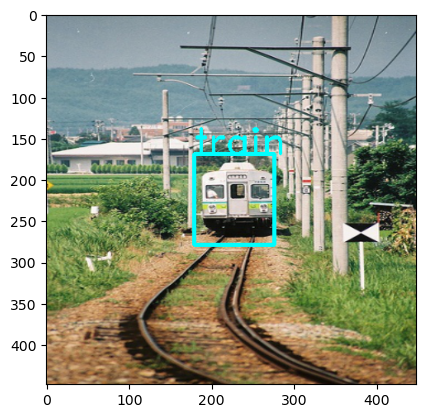

In [30]:
import cv2
import matplotlib.pyplot as plt


def plot_image(filename):
    np_img = cv2.imread(filename)
    np_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
    np_img = cv2.cvtColor(np_img, cv2.COLOR_BGR2RGB)
    shown_img = np_img

    np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))
    np_img = np_img.astype(np.float32)
    np_img = tf.keras.applications.densenet.preprocess_input(np_img)

    xmin, ymin, xmax, ymax, class_num, conf = process_outputs(YOLO(np_img, training=False))
    for i in range(len(xmin)):
        class_name = classes_name[class_num[i]]
        cv2.rectangle(shown_img,
                      (int(xmin[i]), int(ymin[i])),
                      (int(xmax[i]), int(ymax[i])),
                      (0, 255, 255), 3)
        cv2.putText(shown_img,
                    class_name,
                    (int(xmin[i]), int(ymin[i])),
                    2, 1.5, (0, 255, 255), 2)
        if xmin[i] < 0 or ymin[i] < 0 or xmax[i] < 0 or ymax[i] < 0:
            print(class_name, conf[i], xmin[i],
                  ymin[i], xmax[i], ymax[i], conf[i])
        else:
            print(class_name, conf[i])

    plt.imshow(shown_img)
    plt.show()


for i in range(2, 3):
    filename = f'./VOCdevkit_test/VOC2007/JPEGImages/{i:06d}.jpg'
    if os.path.exists(filename):
        plot_image(filename)


## Conclusion

藉由此次competition，我們了解到data augmentation及data balancing的重要，在沒做augmentation與balancing時，model不管怎麼訓練都訓練不好，而做完後就可以比較穩定的框到東西；而model本身的架構也差很多，在沒有batch normalization時，我們的loss會較大，雖然下降幅度也大，可是效果都比有做得差，要怎麼與pretrain model結合也是一門學問；最後的threshold設定我們也發現得太晚，雖然最後上傳到Kaggle的成績不是我們最好的成績，可是至少也有達到80分的水準算是值得慶幸的事。

值得一提的是我們發現batch size與learning rate對model訓練有很大的影響，我們一開始使用助教給的parameter訓練model時第一個epoch的loss有70幾然後再慢慢降，我們想說有降應該就是有成功訓練好，最終loss大在2就下不去了，結果拿來預測時發現預測結果很差；本來想說是不是overfit training data，可是無論我們怎麼測效果都沒有到很好，直到我們把learning rate小一個級數變成1e-5後，第一個epoch的loss就降到5.22然後再慢慢降，最終在40個epoch後就沒什麼在降了，我們再從中取15個epoch、30個epoch與40個epoch的weight做測試，在$w_{conf}$為0.5時，score分別為0.417944、0.403056與0.394043，由此可見1e-5在我們的架構下是較好的learning rate，真的想也沒有想到只差了一個小數點會差這麼多。  
  
另外，我們在data augmentation時也有嘗試助教提過的copy-paste，但sticker的品質與大小以及貼上的位置似乎對整體的performance有相當大的影響，初期在嘗試的過程中有發現某些裁切下來作為sticker的圖片經過去背以後留下的物件輪廓並不鮮明，也有些裁切下的bbox中包含不只一個物件而使得在training過程中會誤判物件，導致最終predict的結果與ground truth相差甚大，雖然後期針對sticker做了篩選，但分數和直接以API做data augmentation來比較沒有較好的效果，因此最後選擇以單純的做法將各個物件的數量平均的augmentation，即可達到相當好的score。